In [1]:
%matplotlib notebook
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Print columns in Measurement class
for c in Measurement.__table__.columns:
    print (c)

measurement.id
measurement.station
measurement.date
measurement.prcp
measurement.tobs


In [11]:
# List columns in Station class
for c in Station.__table__.columns:
    print (c)

station.id
station.station
station.name
station.latitude
station.longitude
station.elevation


In [12]:
# List Station db
conn = engine.connect()
stns = pd.read_sql("SELECT * FROM station", conn)

stns.head()

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


In [13]:
# Preview Measurement db
msrmt = pd.read_sql("SELECT * FROM measurement", conn)

msrmt.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


# Exploratory Climate Analysis

### <font color = blue> Part 1: Precipitation for the last 12 months from last observation </font>

In [14]:
# Calculate the date 1 year ago from today
####################################################################
# Last observation < today-12 months and will return an empty object
####################################################################

last_observ = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

#    Convert object to string and split it
string = str(last_observ[0]).split('-')

year_ago = dt.date(int(string[0]), int(string[1]), int(string[2])) - dt.timedelta(days=365)

print(f'12 months from last observation: {year_ago}')

12 months from last observation: 2016-08-23


In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
precip = session.query(Measurement.date, Measurement.prcp).\
        filter(Measurement.date > year_ago).\
        order_by(Measurement.date.desc()).all()


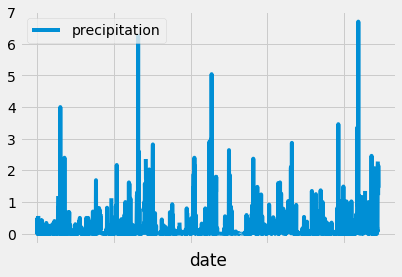

In [16]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df_precip = pd.DataFrame(precip).set_index('date')
df_precip = df_precip.rename(columns={"prcp": "precipitation"})

df_precip.plot(y='precipitation')
plt.legend(loc='upper left')


In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data

In [18]:
df_precip.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


### <font color = blue> Part 2: Most popular station </font>

In [19]:
# How many stations are available in this dataset?
print(engine.execute('SELECT COUNT(DISTINCT(station)) FROM station').fetchall()[0][0]) # Using SQL
session.query(Station.station).group_by(Station.station).count()

9


9

In [20]:
# What are the most active stations?
# List the stations and the counts in descending order.
stations1 = session.query(Measurement.station, func.count(Measurement.station)).\
            group_by(Measurement.station).\
            order_by(func.count(Measurement.station).desc()).all()

print(stations1)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [21]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

a = stations1[0][0] # Choose the station with the highest number of temperature observations

print (f'Station with the highest number of temperature observations: {a}')

# Query the last 12 months of temperature observation data for this station

query_t = session.query(Measurement.tobs, Measurement.id).\
        filter(Measurement.date > year_ago, Measurement.station == a).all()
    

Station with the highest number of temperature observations: USC00519281


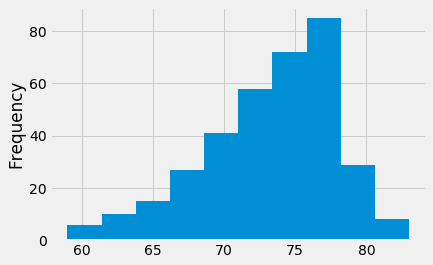

In [22]:
# Make a DataFrame of query
temp_df = pd.DataFrame(query_t)

# Plot the results as a histogram

temp_df['tobs'].plot.hist()


### <font color = blue> Part 3: Trip weather analysis </font>

In [23]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):

    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

In [24]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# arrival = input("Input trip start date in the format %Y-%m-%d: ")
# departure = input("Input trip end date in the format %Y-%m-%d: ")

# Trip dates
arrival = "2017-12-02"
departure = "2017-12-15"

trip0 = arrival.split("-")
trip1 = departure.split("-")

start = dt.date(int(trip0[0]), int(trip0[1]), int(trip0[2])) - dt.timedelta(days=365)
end = dt.date(int(trip1[0]), int(trip1[1]), int(trip1[2])) - dt.timedelta(days=365)

print(f'Previous year MIN, AVE, MAX: {calc_temps(start, end)[0]}')

Previous year MIN, AVE, MAX: (62.0, 70.31868131868131, 78.0)


Text(0,0.5,'Temp (F)')

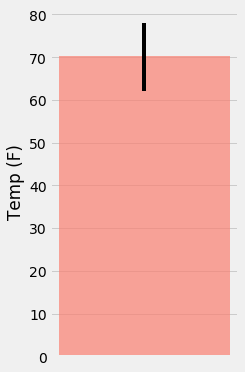

In [25]:
## Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

tmin = calc_temps(start, end)[0][0]
tavg = calc_temps(start, end)[0][1]
tmax = calc_temps(start, end)[0][2]


fig, ax = plt.subplots(figsize=(3,6))

ax.bar(0, tavg, align="center", color = "salmon", alpha = 0.7, yerr = [[tavg-tmin],[tmax-tavg]])
ax.xaxis.set_visible(False)
plt.ylabel('Temp (F)')


In [26]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
    
s = session.query(func.sum(Measurement.prcp), Measurement.station, Station.name,\
                Station.latitude, Station.longitude, Station.elevation).\
                filter(Measurement.station == Station.station,\
                       Measurement.date >= start, Measurement.date <= end).\
                group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()
for t in s:
    print (t)

(5.9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)
(3.0000000000000004, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9)
(1.6700000000000002, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)
(1.5600000000000003, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6)
(1.2400000000000002, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)
(1.1400000000000001, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5)
(0.29000000000000004, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)


## Optional Challenge Assignment

In [27]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.

    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """

    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()[0]
    
daily_normals("01-01")

(62.0, 69.15384615384616, 77.0)

In [28]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date

days, normals = [], []
duration = end - start
for i in range(duration.days + 1):
    day = start + dt.timedelta(i)
    days.append(day)
    normals.append(daily_normals(day.strftime("%m-%d")))

normals

[(62.0, 71.32692307692308, 77.0),
 (67.0, 72.88679245283019, 79.0),
 (66.0, 72.17647058823529, 81.0),
 (64.0, 70.92156862745098, 78.0),
 (61.0, 69.3921568627451, 78.0),
 (58.0, 69.2, 79.0),
 (60.0, 70.27450980392157, 83.0),
 (64.0, 71.90196078431373, 80.0),
 (61.0, 71.24528301886792, 78.0),
 (64.0, 72.38775510204081, 78.0),
 (64.0, 70.88235294117646, 79.0),
 (65.0, 70.9423076923077, 80.0),
 (65.0, 71.18, 78.0),
 (62.0, 71.34, 79.0)]

In [29]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
date = pd.DataFrame(days, columns=['date'])
normals_df = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'])
normals_df = normals_df.assign(date=date.values) # Add columns with dates to 'normals'
normals_df = normals_df.set_index('date')
normals_df.head()

,tmin,tavg,tmax
date,,,
2016-12-02,62.0,71.326923,77.0
2016-12-03,67.0,72.886792,79.0
2016-12-04,66.0,72.176471,81.0
2016-12-05,64.0,70.921569,78.0
2016-12-06,61.0,69.392157,78.0


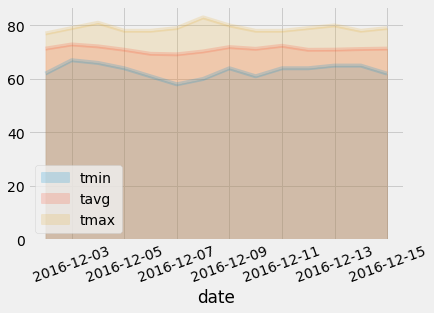

In [30]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot.area(stacked=False, alpha = 0.2, rot = 20)